# Amazon Fine Food Reviews Analysis
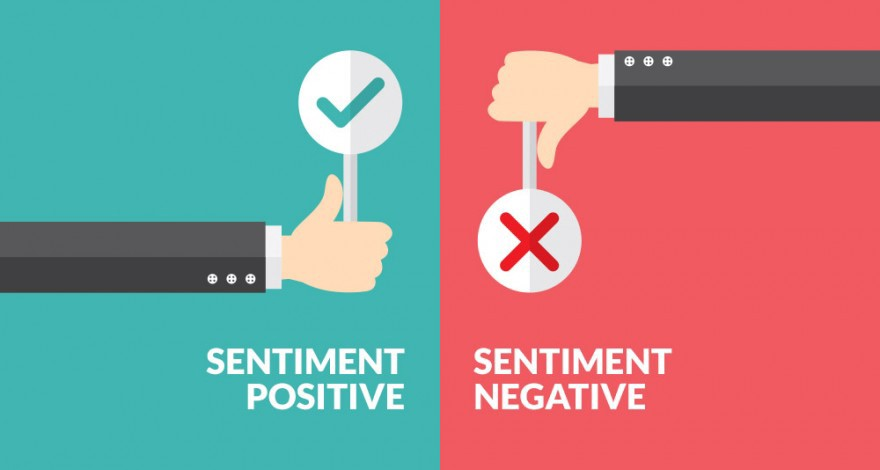

### Context
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

###### Information about dataset
###### Reviews from Oct 1999 - Oct 2012
###### 568,454 reviews
###### 256,059 users
###### 74,258 products
###### 260 users with > 50 reviews

## Attribution Information
1. ID
2. ProductId
3. UserId
4. ProfileName
5. HelpfulnessNumerator - Number of users who found the review helpful
6. HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
7. Score - Rating between 1 and 5 ****
8. Time - Timestamp for the review
9. Summary - Brief summary of the review
10. Text - Text of the review *****


### Objective : 
Given a review, we have to determine the review is either positive (4 or 5) or negative (1 or 2)
 Review 3 - is neutral so we have to ignore them 

In [1]:
# import basic packages

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')


import nltk
import string
import sqlite3

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as po
from plotly.subplots import make_subplots
from prettytable import PrettyTable

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#connect to database

con=sqlite3.connect('database.sqlite')

In [4]:
filtered_data=pd.read_sql_query("""select * from reviews where score !=3 limit 10000""",con)
filtered_data.shape


(10000, 10)

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
filtered_data['Score'].value_counts()

5    6776
4    1545
1    1033
2     646
Name: Score, dtype: int64

In [7]:
def partition(x):
    if x <3:
        return 0
    return 1

# Changing reviews with score less than 3 to be negative (0) and more than 3 to be positive(1)

actualScore = filtered_data['Score']
PositiveNegative = actualScore.map(partition)
filtered_data['Score'] = PositiveNegative
print("Number of data points in our dataset", filtered_data.shape)
filtered_data.head(10)

Number of data points in our dataset (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [8]:
filtered_data['Score'].value_counts()

1    8321
0    1679
Name: Score, dtype: int64

# Missing value check

In [9]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [10]:
filtered_data.isna().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName               False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                   False
Text                      False
dtype: bool

In [11]:
#There are no missing entries in the dataset

In [12]:
df=filtered_data[['ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Score','Summary','Text']]

In [13]:
df.head()

,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,B001E4KFG0,1,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,0,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,1,1,1,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,3,3,0,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,0,0,1,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
# Remove duplicates

def drop_dup(df):
    if df.duplicated().any() == True:
        print('The total duplicate row before removing duplicate:', df.duplicated().sum())
        df.drop_duplicates(inplace=True , keep = 'last')  # Remove duplicates
        df = df.reset_index(drop=True) #Reset the index
        print('The total duplicate row after removing duplicate:', df.duplicated().sum(), ' \nshape of dataset after removing duplicate columns :',df.shape)
    else:
        return 'No duplicate entries'
drop_dup(df)

The total duplicate row before removing duplicate: 2
The total duplicate row after removing duplicate: 0  
shape of dataset after removing duplicate columns : (9998, 6)


In [15]:
df.Score.value_counts()

1    8319
0    1679
Name: Score, dtype: int64

1    8319
0    1679
Name: Score, dtype: int64
------------------------------


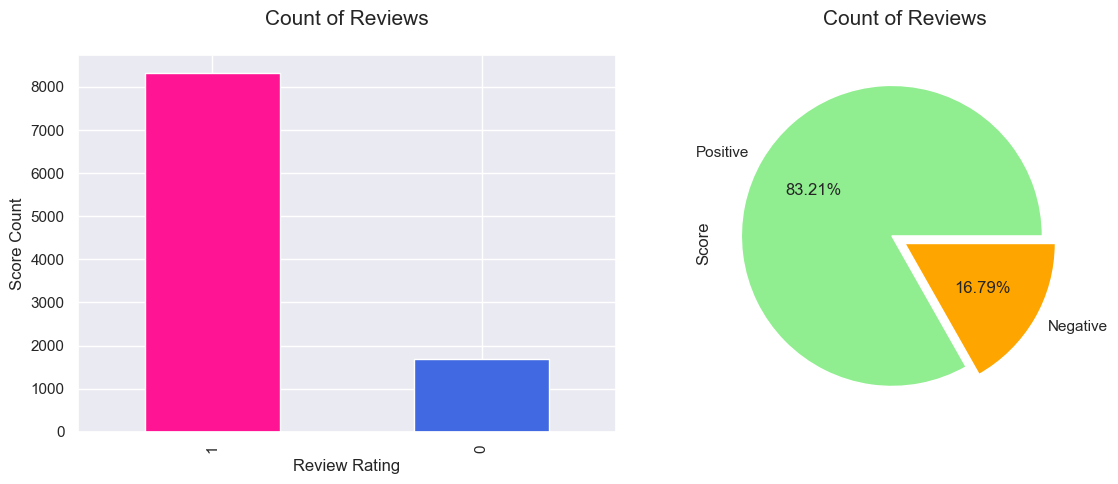

In [16]:

score_value_counts = df.Score.value_counts()
print(score_value_counts)
print('---'*10)

fig, axes = plt.subplots(1,2, figsize=(12,5))
labels = ['Positive', 'Negative']

color = ['deeppink','royalblue']
score_value_counts.plot(kind='bar', color =color, ax=axes[0],ylabel='Score Count',xlabel='Review Rating' )
axes[0].set_title('Count of Reviews\n', fontsize = 15)


colors =['lightgreen','orange']
score_value_counts.plot(kind='pie', autopct='%1.2f%%',labels = labels, colors=colors, explode=[0.1,0.],ax=axes[1] )
axes[1].set_title('Count of Reviews\n', fontsize = 15)
plt.tight_layout()
plt.show()

In [17]:
df.nunique().sort_values()


Score                        2
HelpfulnessNumerator        58
HelpfulnessDenominator      61
ProductId                 1481
Summary                   8488
Text                      9559
dtype: int64

# Feature Engineering

In [18]:
df['review'] = df['Summary'] +' '+ df['Text']

In [19]:
df['review'][11]

'My cats LOVE this "diet" food better than their regular food One of my boys needed to lose some weight and the other didn\'t.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week.'

In [20]:
df['review'][1000]

'an excellent alternative to regular Gatorade Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you\'re on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.<br /><br />I highly recommend this drink if you need extra carbs or electrolytes after exercising; it replenishes them very well without the extra sugar found in regular Gatorade.'

# Text cleaning

Some of the common text preprocessing / cleaning steps are:

* Tokenization
* Casefolding
* Removal of Punctuations
* Removal of Stopwords
* Removal of Frequent words
* Removal of Rare words
* Number to words/ignoring numbers
* Normaliation using Stemming or Lemmatization 
* Removal/Conversion of emojis and emoticons
* Removal of URLs
* Removal of HTML tags
* Chat words conversion
* Spelling correction

As for sentiment analysis, negative words , Emojis and numbers are all important we will convert them to text


In [21]:
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize, WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS 
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import wordnet
from  num2words import num2words
import emoji
from bs4 import BeautifulSoup


nltk.download('stopwords') 
nltk.download('vader_lexicon') 
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Madhavi_J\AppData\Roaming\nltk_data...
[nltk_data]   Package word

True

In [22]:
negative_words=['never',  'no', 'nor', 'not','don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',"didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]
my_stopwords= set( word for word in stopwords.words('english')if word not in negative_words)



In [23]:
def decontracted(phrase):
    phrase = re.sub("don\'t", 'do not',phrase)
    phrase = re.sub('ain', 'am not',phrase)
    phrase = re.sub('aren', 'are not',phrase)
    phrase = re.sub("aren\'t", 'are not',phrase)
    phrase = re.sub('couldn','could not',phrase)
    phrase = re.sub("couldn\'t", 'could not',phrase)
    phrase = re.sub('didn','did not',phrase)
    phrase = re.sub("didn\'t",'dit not',phrase)
    phrase = re.sub('doesn', 'does not',phrase)
    phrase = re.sub("doesn\'t",'does not',phrase)
    phrase = re.sub('hadn','had not',phrase)
    phrase = re.sub("hadn\'t",'had not',phrase)
    phrase = re.sub('hasn','has not',phrase)
    phrase = re.sub("hasn\'t",'has not',phrase)
    phrase = re.sub('haven','have not',phrase)
    phrase = re.sub("haven\'t",'have not',phrase)
    phrase = re.sub('isn','is not',phrase)
    phrase = re.sub("isn\'t",'is not',phrase)
    phrase = re.sub('mightn','might not',phrase)
    phrase = re.sub("mightn\'t",'might not',phrase)
    phrase = re.sub('mustn','must not',phrase)
    phrase = re.sub("mustn\'t",'must not',phrase)
    phrase = re.sub('needn','need not',phrase)
    phrase = re.sub("needn\'t",'need not',phrase)
    phrase = re.sub('shan','shall not',phrase)
    phrase = re.sub("shan\'t",'shall not',phrase)
    phrase = re.sub('shouldn','should not',phrase)
    phrase = re.sub("shouldn\'t",'should not',phrase)
    phrase = re.sub('wasn','was not',phrase)
    phrase = re.sub("wasn\'t",'was not',phrase)
    phrase = re.sub('weren','were not',phrase)
    phrase = re.sub("weren\'t",'were not',phrase)
    phrase = re.sub("won\'t",'will not',phrase)
    phrase = re.sub('wouldn','would not',phrase)
    phrase = re.sub("wouldn\'t",'would not',phrase)
    phrase = re.sub(r"\'s'", "is", phrase)
    phrase = re.sub(r"\'d", "would", phrase)
    phrase = re.sub(r"\'ll", "will", phrase)
    phrase = re.sub(r"\'ve", "have", phrase)
    phrase = re.sub(r"\'m", "am", phrase)
    phrase = re.sub(r"\'re", "are", phrase)
    phrase=re.sub(r"\'t" , ' ', phrase)

    return phrase
decontracted("shouldn\'t")


'should not '

In [24]:
from tqdm import tqdm
lem=WordNetLemmatizer()
stopwords_list=stopwords.words('english')
PUNCT_TO_REMOVE = string.punctuation
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
corpus=[]

for text in tqdm(df['review'].values):
    text=text.lower()
    text=re.sub('<br />', ' ', text)
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))# Punctuation removal
    text=emoji.demojize(text,language='en' ) # convert emoijis
    text = re.sub(r"http\S+","",text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = decontracted(text)
    text = re.sub('[^a-zA-Z0-9]+',' ', text) 
    pos_tagged_text = nltk.pos_tag(word_tokenize(text))
    lemmed_words=[lem.lemmatize(word, wordnet_map.get(pos[0], wordnet.VERB)) for word, pos in pos_tagged_text if word not in my_stopwords]
    text=' '.join(lemmed_words)
    corpus.append(text.strip()) 

100%|█████████████████████████████████████████████████████████████████████████████| 9998/9998 [01:20<00:00, 123.50it/s]


In [25]:
df['processed_review']=corpus

In [26]:
df['processed_review'][1000]

'excellent alternative regular gatorade gatorade g2 way go want benefit gatorade without quite much sugar prediabetes state day drink type gatorade instead regular gatorade noticeably sugar really good thing still replenish carbs electrolyte exercise without put unnecessary extra sugar system g2 come flavor include fruit punch grape youre go advantage bottle gatorade bottle small carry much easy take regular large size bottle gatorade g2 highly recommend drink need extra carbs electrolyte exercise replenish well without extra sugar find regular gatorade'

# Sentiment Analysis Model building

Sentiment analysis can be done in below ways in python

* Vader
* ML -Naive bayes or Random Forest
* DL- LSTM and GRU

We will use Vader and ML Algorithms in this notebook 

## Vader Sentiment Analysis

VADER( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

First, we will create a sentiment intensity analyzer to categorize our dataset. Then, we use the polarity scores method to determine the sentiment.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [28]:
sia = SentimentIntensityAnalyzer()


In [29]:
example = df['review'][6018]
print(example)
print(sia.polarity_scores(example))

Great first food My baby loves this. It's a great first food to start with when teaching your baby to have solids. The pouch makes it easy to get the product out, without making a mess and the lid is easy to refasten, so you can use it again over a few feeds.
{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.9629}


In [30]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.9629}

In [31]:
res = {} # initialising an empty dictionary to store sentiment score
for index,row in tqdm(df.iterrows(),total= len(df)):
    text = row['review']
    #text_blob=TextBlob(text)
    #text_blob.polarity
    res[index] = sia.polarity_scores(text)

100%|█████████████████████████████████████████████████████████████████████████████| 9998/9998 [00:15<00:00, 643.18it/s]


In [32]:
vaders = pd.DataFrame(res).T
vaders.reset_index().rename(columns={'index' : 'Id'})
vaders

,neg,neu,pos,compound
0,0.000,0.677,0.323,0.9583
1,0.127,0.873,0.000,-0.5664
2,0.087,0.763,0.150,0.8265
3,0.000,1.000,0.000,0.0000
4,0.000,0.506,0.494,0.9661
...,...,...,...,...
9995,0.119,0.724,0.158,0.5720
9996,0.165,0.703,0.132,0.0534
9997,0.036,0.563,0.400,0.9718
9998,0.168,0.707,0.124,-0.6759


In [33]:
vaders.iloc[10]

neg         0.0160
neu         0.8380
pos         0.1460
compound    0.9787
Name: 10, dtype: float64

In [34]:
df_final = pd.concat([vaders,df], axis=1)
df_final

,neg,neu,pos,compound,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,review,processed_review
0,0.000,0.677,0.323,0.9583,B001E4KFG0,1,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,good quality dog food buy several vitality can...
1,0.127,0.873,0.000,-0.5664,B00813GRG4,0,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,not advertised product arrive label jumbo salt...
2,0.087,0.763,0.150,0.8265,B000LQOCH0,1,1,1,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",delight say confection around century light pi...
3,0.000,1.000,0.000,0.0000,B000UA0QIQ,3,3,0,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,cough medicine look secret ingredient robituss...
4,0.000,0.506,0.494,0.9661,B006K2ZZ7K,0,0,1,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...,great taffy great taffy great price wide assor...
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.119,0.724,0.158,0.5720,B000EM6PC6,1,1,1,the greatest tea in my opinion,I was so disappointed to find that the two sto...,the greatest tea in my opinion I was so disapp...,great tea opinion disappointed find two store ...
9996,0.165,0.703,0.132,0.0534,B000EM6PC6,1,1,1,Tea,It's very hard to find this product in local g...,Tea It's very hard to find this product in loc...,tea hard find product local grocery store loos...
9997,0.036,0.563,0.400,0.9718,B000EM6PC6,1,1,1,GREAT TEA,GREAT TEA. IF ANYONE HAS NOT TRIED LOOSE TEA ...,GREAT TEA GREAT TEA. IF ANYONE HAS NOT TRIED ...,great tea great tea anyone not try loose tea n...
9998,0.168,0.707,0.124,-0.6759,B000EM6PC6,2,3,1,"Help, My stomach gets upset with this tea.",I have always loved Lipton teas. It is a daily...,"Help, My stomach gets upset with this tea. I h...",help stomach get upset tea always love lipton ...


In [35]:
final=df_final.copy()
final.reset_index(inplace=True)
final.iloc[6019]

index                                                                  6020
neg                                                                   0.028
neu                                                                   0.681
pos                                                                   0.291
compound                                                             0.9724
ProductId                                                        B005O8BLLU
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Score                                                                     1
Summary                                                    Great first food
Text                      This is excellent for a baby's first taste. Th...
review                    Great first food This is excellent for a baby'...
processed_review          great first food excellent baby first taste po...
Name: 6019, 

In [36]:

negative_condition = (final['compound'] <= -0.05)
positive_condition = (final['compound'] >= 0.05)
neutral_condition =  (final['compound'] > -0.05)&(final['compound'] < 0.05)


conditions = [negative_condition, positive_condition, neutral_condition]
values = ['negative', 'positive', 'positive']

final['sentiment'] = tqdm(np.select(conditions, values))

100%|█████████████████████████████████████████████████████████████████████████| 9998/9998 [00:00<00:00, 1432634.74it/s]


In [37]:
final[(final['sentiment'] =='positive') & (final.Score==0)]

,index,neg,neu,pos,compound,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,review,processed_review,sentiment
3,3,0.000,1.000,0.000,0.0000,B000UA0QIQ,3,3,0,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,cough medicine look secret ingredient robituss...,positive
12,12,0.028,0.931,0.041,0.2960,B0009XLVG0,1,1,0,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,My Cats Are Not Fans of the New Food My cats h...,cat not fan new food cat happily eat felidae p...,positive
16,16,0.149,0.658,0.193,0.5049,B001GVISJM,0,0,0,poor taste,I love eating them and they are good for watch...,poor taste I love eating them and they are goo...,poor taste love eat good watch tv look movie n...,positive
57,57,0.000,1.000,0.000,0.0000,B001EO5TPM,2,2,0,stale product.,Arrived in 6 days and were so stale i could no...,stale product. Arrived in 6 days and were so s...,stale product arrive 6 day stale could not eat...,positive
67,67,0.103,0.755,0.143,0.9590,B0059WXJKM,0,1,0,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...,Warning! WARNING! -ALCOHOL SUGARS! Buyer Bew...,warn warn alcohol sugar buyer beware please sw...,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961,9963,0.051,0.697,0.252,0.9222,B0034KP00S,0,2,0,Not a big fan of these,All the 5-star reviews convinced me to buy the...,Not a big fan of these All the 5-star reviews ...,not big fan 5star review convince buy thesei w...,positive
9962,9964,0.025,0.827,0.148,0.8441,B0034KP00S,0,3,0,Tastes like Pistachios,These taste good and are edible but I am only ...,Tastes like Pistachios These taste good and ar...,taste like pistachio taste good edible give 1 ...,positive
9965,9967,0.143,0.676,0.181,0.4570,B004FRT992,0,0,0,No good.,I am looking for a replacement for Coca Cola a...,No good. I am looking for a replacement for Co...,no good look replacement coca cola read positi...,positive
9968,9970,0.039,0.787,0.173,0.9722,B00270Z6FA,1,3,0,item is delicious; price is ridiculous,During my recent visit to New Orleans in June ...,item is delicious; price is ridiculous During ...,item delicious price ridiculous recent visit n...,positive


In [38]:
final.sentiment.value_counts()

positive    9038
negative     960
Name: sentiment, dtype: int64

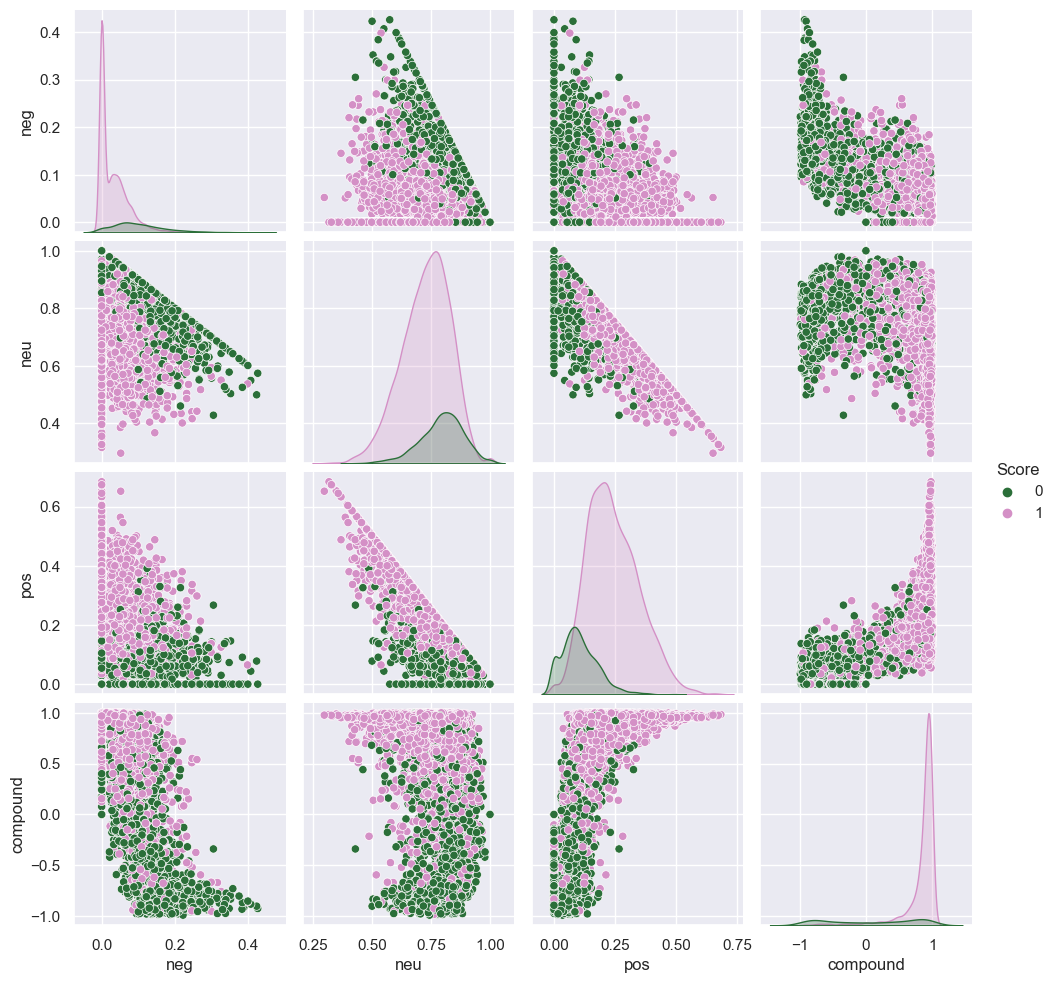

In [39]:
sns.pairplot(data= final, vars=['neg', 'neu','pos', 'compound'], hue= 'Score', palette='cubehelix')
plt.show()

1    8103
0     935
Name: Score, dtype: int64
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


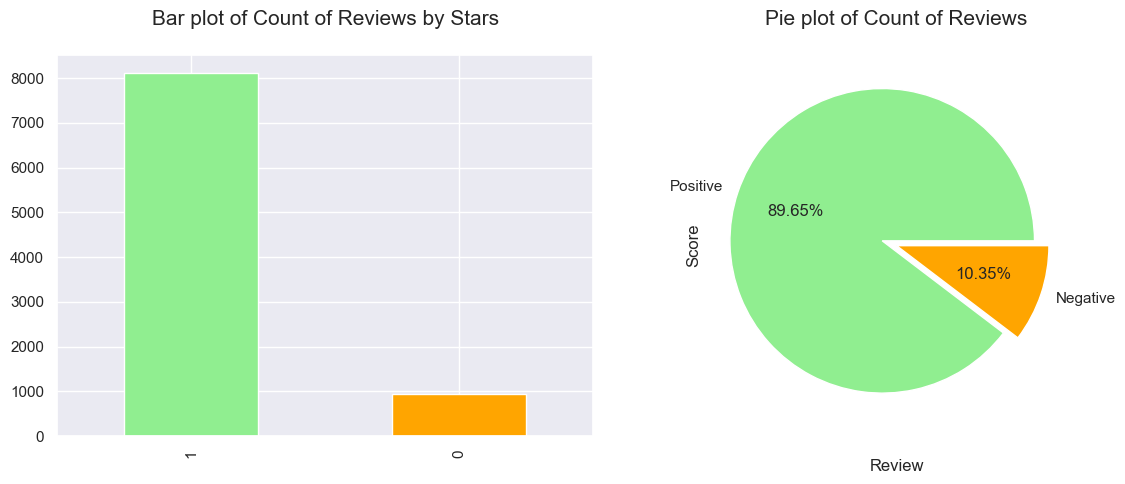

In [40]:
score_value_counts = (final[final['compound']>= -0.05]['Score']).value_counts()
print(score_value_counts)
print('---'*65)
fig, axes = plt.subplots(1,2, figsize=(12,5))
score_value_counts.plot(kind='bar', color =colors, ax=axes[0] )
plt.ylabel('Score Count')
plt.xlabel('\nReview')
axes[0].set_title('Bar plot of Count of Reviews by Stars\n', fontsize = 15)
labels = ['Positive','Negative']
score_value_counts.plot.pie(autopct='%1.2f%%',labels = labels, colors=colors, explode=[0.1,0.],ax=axes[1] )
axes[1].set_title('Pie plot of Count of Reviews\n', fontsize = 15)
plt.tight_layout()
plt.show()

__Observation__:

We can see that Vader has classified 9038 reviews as Positive+Neutral but out them 935 reviews are actually Negative as per the Score provided with data. 

0    744
1    216
Name: Score, dtype: int64
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


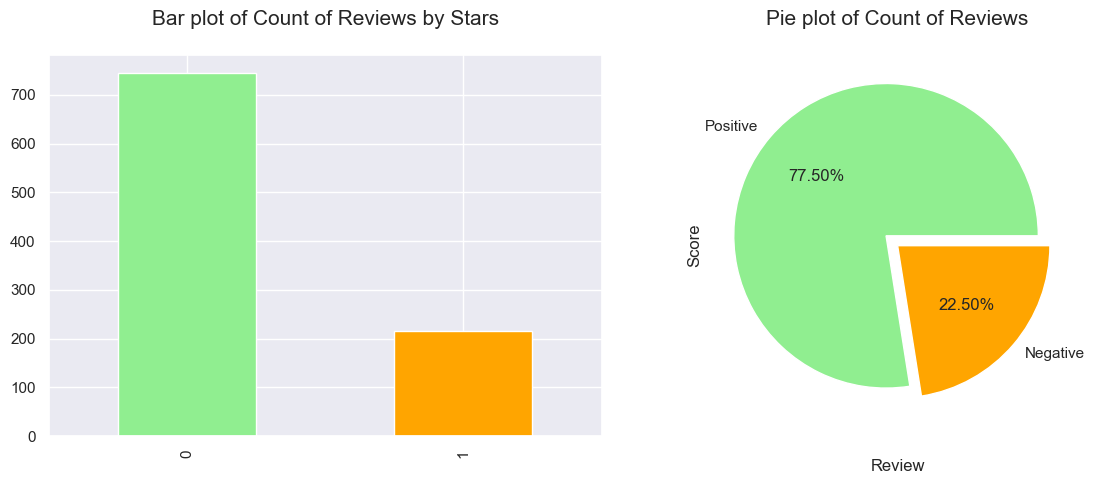

In [41]:
score_value_counts = (final[final['compound']<-0.05]['Score']).value_counts()
print(score_value_counts)
print('---'*65)
fig, axes = plt.subplots(1,2, figsize=(12,5))
score_value_counts.plot(kind='bar', color =colors, ax=axes[0] )
plt.ylabel('Score Count')
plt.xlabel('\nReview')
axes[0].set_title('Bar plot of Count of Reviews by Stars\n', fontsize = 15)
labels = ['Positive','Negative']
score_value_counts.plot.pie(autopct='%1.2f%%',labels = labels, colors=colors, explode=[0.1,0.],ax=axes[1] )
axes[1].set_title('Pie plot of Count of Reviews\n', fontsize = 15)
plt.tight_layout()
plt.show()

__Observation__:

We can see that Vader has 960 reviews as Negative out of which 77% of reviews are Actually postive as Per Score provide with Dataset. 

# Wordcloud

In [42]:
from wordcloud import WordCloud
wc_negative = WordCloud(width=800,
               height=400,
               min_font_size=2,
               max_font_size=100,
               min_word_length=3,
               max_words=100,
               background_color='white',
               colormap='Reds'
              )
wc_positive = WordCloud(width=800,
               height=400,
               min_font_size=5,
               max_font_size=100,
               min_word_length=3,
               max_words=100,
               background_color='white',
               colormap='Blues'
              )

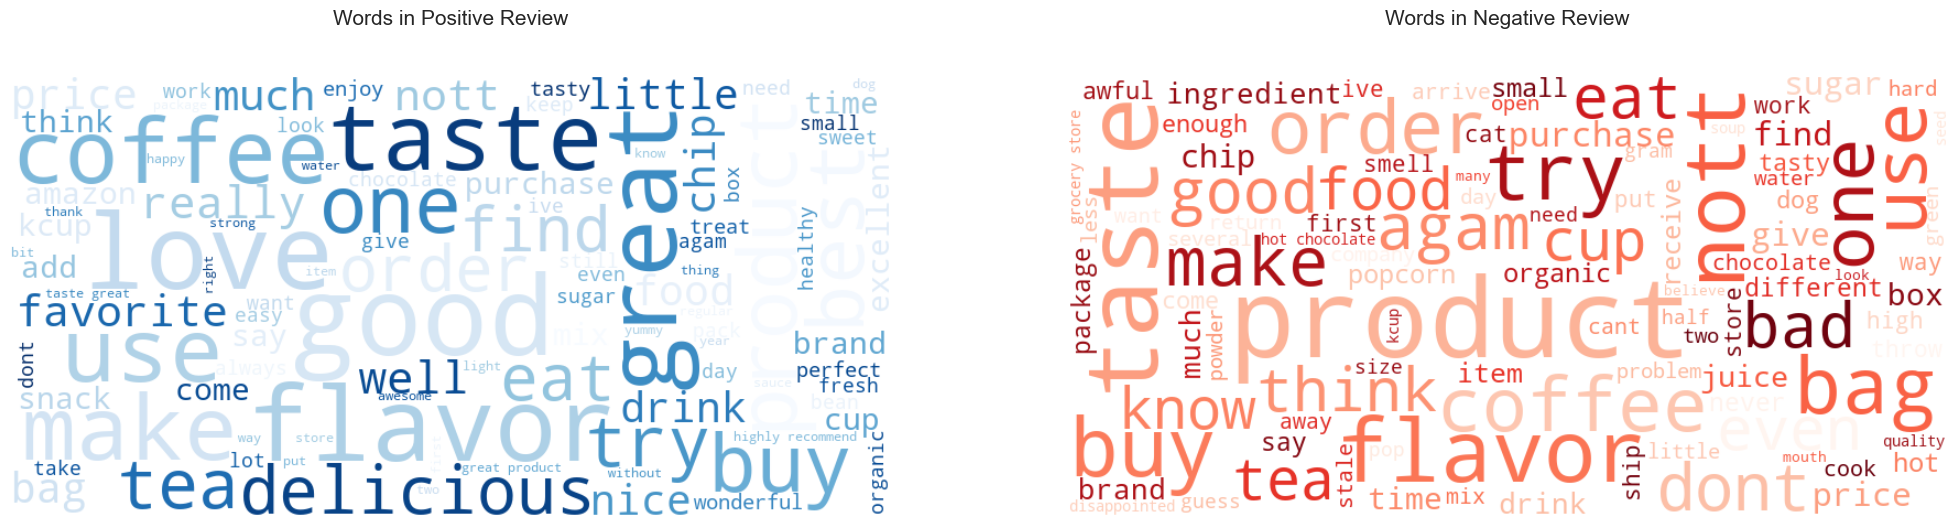

In [43]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
wc_pos = wc_positive.generate(final[final['neg']==0]['processed_review'].str.cat(sep = " "))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Words in Positive Review\n\n', fontsize=15)

plt.subplot(122)

wc_neg = wc_negative.generate(final[final['pos']==0]['processed_review'].str.cat(sep = " "))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Words in Negative Review\n\n', fontsize=15)
plt.show()

__Observation__:
* the positive reviews contains words like 'Good', 'Delicious','Fresh','Wonderful','Favourite','best','Great' etc
* Negative reviews mostly comprise of 'bad','dont' , 'aweful','not','cant','terrible','never','throw'etc

In [44]:
final.sentiment.value_counts()


positive    9038
negative     960
Name: sentiment, dtype: int64

positive    90.39808
negative     9.60192
Name: sentiment, dtype: float64
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


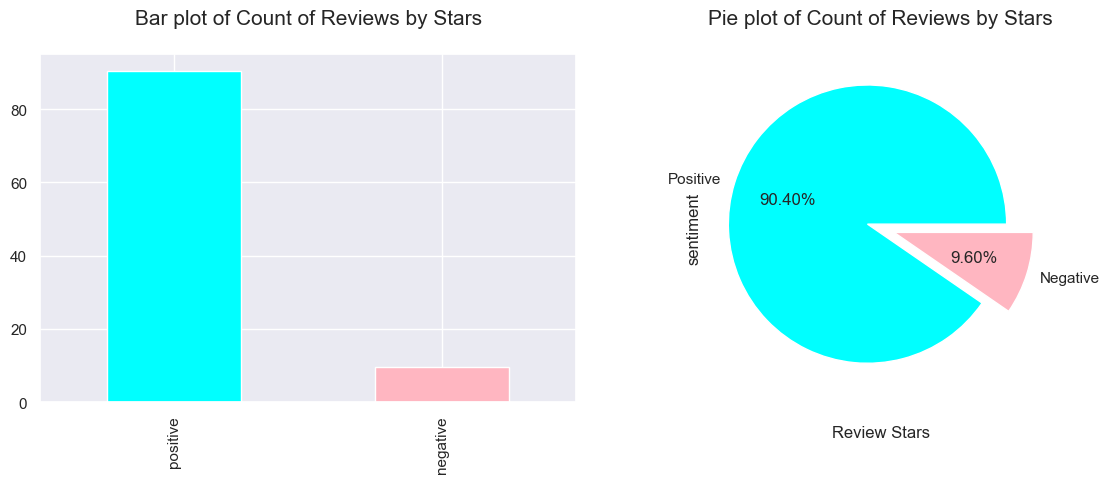

In [45]:
sentiment_value_counts = final.sentiment.value_counts()*100/len(df)
print(sentiment_value_counts)
colors=['cyan', 'lightpink', 'purple']

print('---'*65)
fig, axs = plt.subplots(1,2, figsize=(12,5))
labels = ['Positive','Negative']
sentiment_value_counts.plot(kind='bar', color =colors, ax=axs[0], )
plt.ylabel('Score Count')
plt.xlabel('\nReview Stars')
axs[0].set_title('Bar plot of Count of Reviews by Stars\n', fontsize = 15)

sentiment_value_counts.plot.pie(autopct='%1.2f%%',labels = labels, colors=colors, explode=[0.1,0.1],ax=axs[1] )
axs[1].set_title('Pie plot of Count of Reviews by Stars\n', fontsize = 15)
plt.tight_layout()
plt.show()

# Model Building
   
* Text analytics involves high dimentionality. To handle high dimentionality we will be using below models 
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
    * Random Forest
   

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score,roc_curve,auc,RocCurveDisplay,ConfusionMatrixDisplay
    

# Vectorization

In [47]:
tfidf=TfidfVectorizer()
x=tfidf.fit_transform(final['processed_review']).toarray()

In [48]:
y=df.Score

# Treat Target Imbalance 

In [49]:
final.Score.value_counts()

1    8319
0    1679
Name: Score, dtype: int64

In [50]:
from imblearn.over_sampling import  SMOTE
smote = SMOTE()
x_over, y_over = smote.fit_resample(x,y)

In [51]:
x_over.shape

(16638, 20061)

In [52]:
x.shape

(9998, 20061)

In [53]:
x_train, x_test, y_train, y_test= train_test_split(x_over, y_over , test_size=0.2, random_state=42)

## GaussianNB

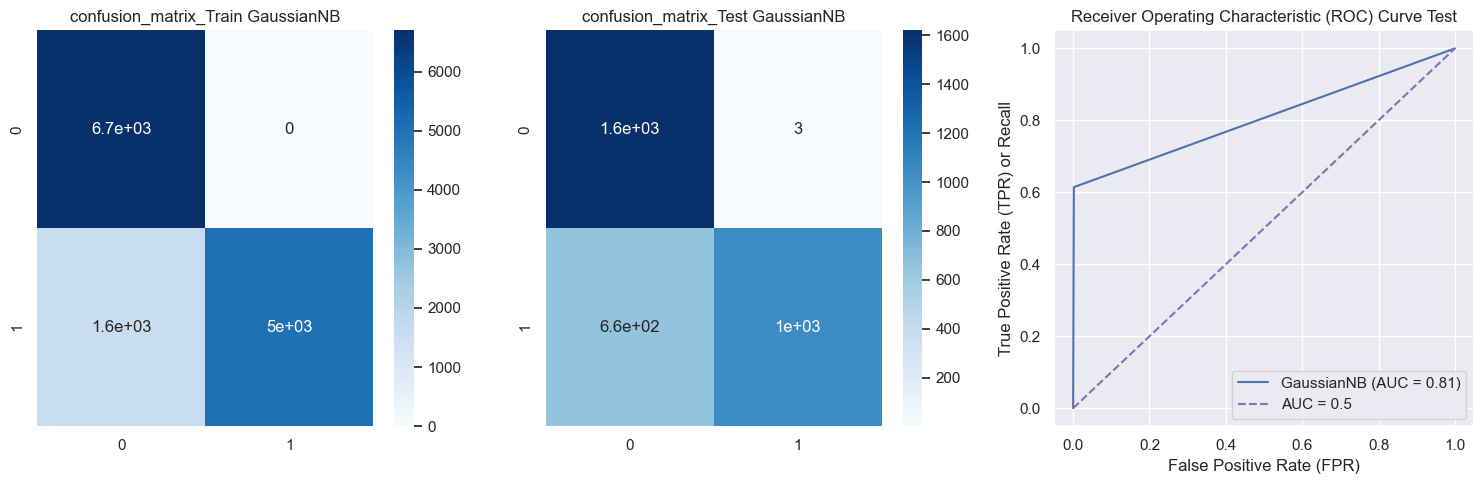

,Model,Train_auc_score,Train_accuracy,CV_Mean_Train_Accuracy,Train_f1,Test_auc_score,Test_accuracy,CV_Mean_Test_Accuracy,Test_f1
0,GaussianNB,0.88,0.881,0.795,0.864,0.806,0.801,0.742,0.76


In [54]:
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, y_train)
y_pred_train_gnb= clf_gnb.predict(x_train)
y_pred_test_gnb= clf_gnb.predict(x_test)

Train_AUC_gnb = roc_auc_score(y_train,clf_gnb.predict_proba(x_train)[:,1])
Train_accuracy_gnb = accuracy_score(y_train,y_pred_train_gnb)
Train_f1_gnb = f1_score(y_train,y_pred_train_gnb)

Test_AUC_gnb = roc_auc_score(y_test,clf_gnb.predict_proba(x_test)[:,1])
Test_accuracy_gnb = accuracy_score(y_test,y_pred_test_gnb)
Test_f1_gnb = f1_score(y_test,y_pred_test_gnb)


# Cross Validation 
gnb_train_accuracy = cross_val_score(clf_gnb, x_train, y_train, cv=10).mean()
gnb_test_accuracy = cross_val_score(clf_gnb, x_test, y_test, cv=10).mean()


####visualizations

cm_test = confusion_matrix(y_test, y_pred_test_gnb)
cm_train = confusion_matrix(y_train, y_pred_train_gnb)   


plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Train GaussianNB')

plt.subplot(1,3,2)
sns.heatmap(cm_test, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Test GaussianNB')


plt.subplot(1,3,3)
fpr, tpr, _ = roc_curve(y_test, y_pred_test_gnb, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'GaussianNB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'm--', label='AUC = 0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#summary table
summary_table = PrettyTable(["Model", "Train_auc_score", "Train_accuracy",'CV_Mean_Train_Accuracy',"Train_f1" ,"Test_auc_score",'Test_accuracy','CV_Mean_Test_Accuracy' ,'Test_f1']) #heading
summary_table.add_row(["GaussianNB",round(Train_AUC_gnb,3),round(Train_accuracy_gnb, 3),round(gnb_train_accuracy ,3), round(Train_f1_gnb,3),round(Test_AUC_gnb,3),round(Test_accuracy_gnb,3), round(gnb_test_accuracy ,3),round(Test_f1_gnb,3) ])

table = pd.read_html(summary_table.get_html_string())
Gaussian_NB_Classifier_Result = table[0]
Gaussian_NB_Classifier_Result

# BernouliNB

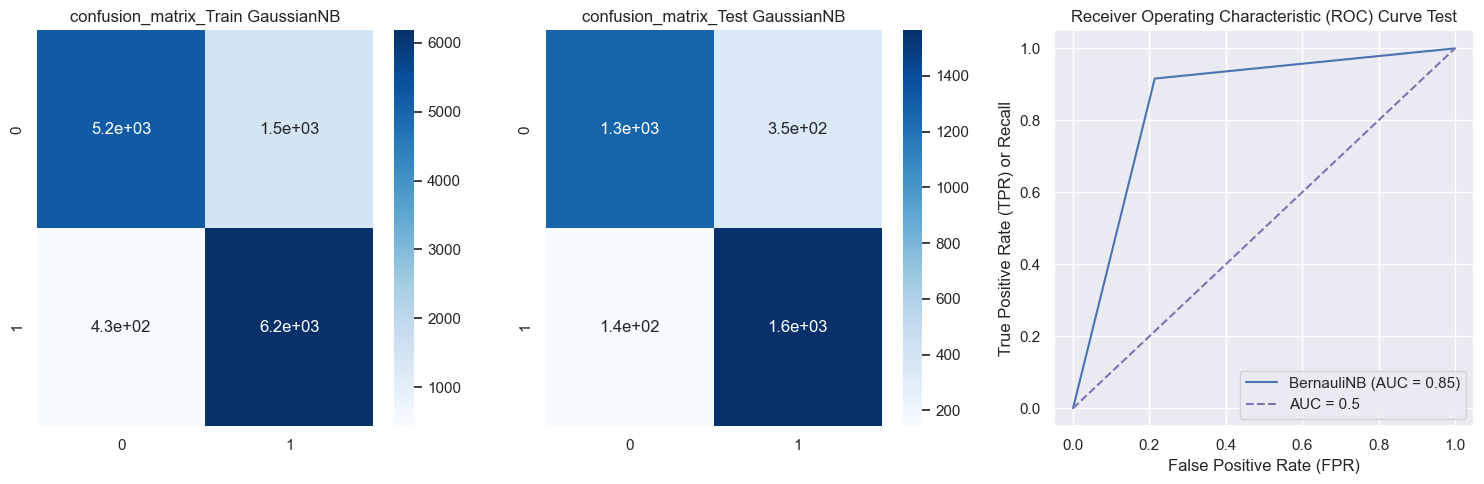

,Model,Train_auc_score,Train_accuracy,CV_Mean_Train_Accuracy,Train_f1,Test_auc_score,Test_accuracy,CV_Mean_Test_Accuracy,Test_f1
0,BernoulliNB,0.952,0.857,0.841,0.866,0.941,0.853,0.814,0.864


In [55]:
clf_bnb = BernoulliNB()
clf_bnb.fit(x_train, y_train)
y_pred_train_bnb= clf_bnb.predict(x_train)
y_pred_test_bnb= clf_bnb.predict(x_test)

Train_AUC_bnb = roc_auc_score(y_train,clf_bnb.predict_proba(x_train)[:,1])
Train_accuracy_bnb = accuracy_score(y_train,y_pred_train_bnb)
Train_f1_bnb = f1_score(y_train,y_pred_train_bnb)

Test_AUC_bnb = roc_auc_score(y_test,clf_bnb.predict_proba(x_test)[:,1])
Test_accuracy_bnb = accuracy_score(y_test,y_pred_test_bnb)
Test_f1_bnb = f1_score(y_test,y_pred_test_bnb)

# Cross Validation 
bnb_train_accuracy = cross_val_score(clf_bnb, x_train, y_train, cv=10).mean()
bnb_test_accuracy = cross_val_score(clf_bnb, x_test, y_test, cv=10).mean()


####visualizations

cm_test = confusion_matrix(y_test, y_pred_test_bnb)
cm_train = confusion_matrix(y_train, y_pred_train_bnb)   


plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Train GaussianNB')

plt.subplot(1,3,2)
sns.heatmap(cm_test, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Test GaussianNB')


plt.subplot(1,3,3)
fpr, tpr, _ = roc_curve(y_test, y_pred_test_bnb, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'BernauliNB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'm--', label='AUC = 0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#Summary table
summary_table = PrettyTable(["Model", "Train_auc_score", "Train_accuracy",'CV_Mean_Train_Accuracy',"Train_f1" ,"Test_auc_score",'Test_accuracy','CV_Mean_Test_Accuracy' ,'Test_f1']) #heading
summary_table.add_row(["BernoulliNB",round(Train_AUC_bnb,3),round(Train_accuracy_bnb, 3),round(bnb_train_accuracy ,3),round(Train_f1_bnb,3),round(Test_AUC_bnb,3),round(Test_accuracy_bnb,3), round(bnb_test_accuracy ,3),round(Test_f1_bnb,3) ])

table = pd.read_html(summary_table.get_html_string())
Bernoulli_NB_Classifier_Result = table[0]
Bernoulli_NB_Classifier_Result

# Multinomial NB

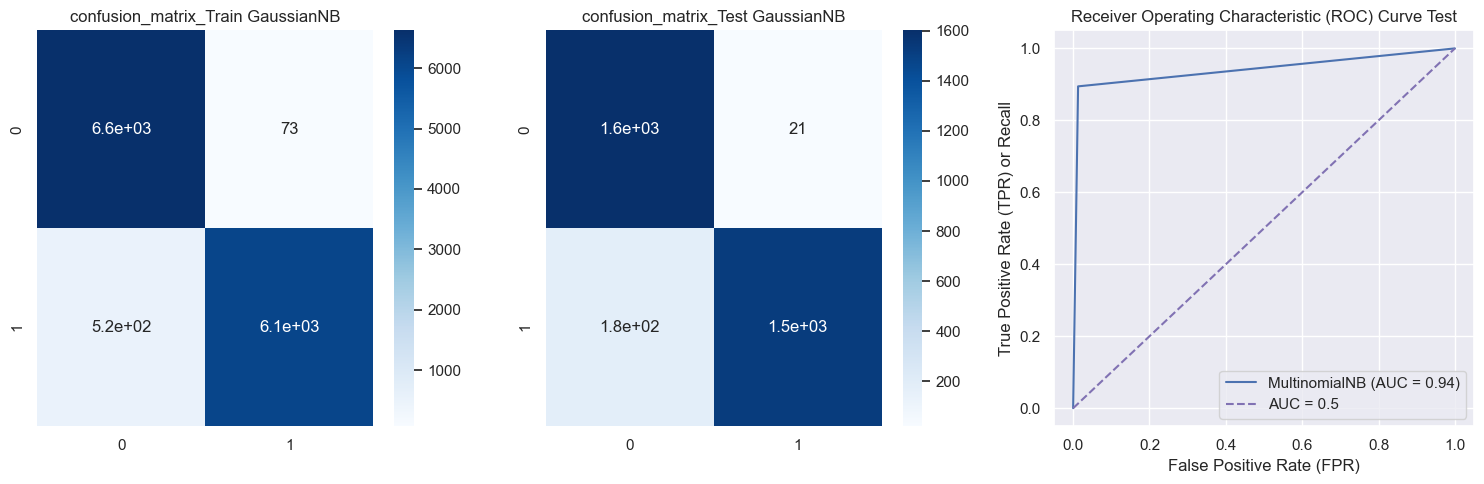

,Model,Train_auc_score,Train_accuracy,CV_Mean_Train_Accuracy,Train_f1,Test_auc_score,Test_accuracy,CV_Mean_Test_Accuracy,Test_f1
0,MultinomialNB,0.993,0.956,0.929,0.954,0.99,0.94,0.909,0.938


In [56]:
clf_mnb = MultinomialNB()
clf_mnb.fit(x_train, y_train)
y_pred_train_mnb= clf_mnb.predict(x_train)
y_pred_test_mnb= clf_mnb.predict(x_test)

Train_AUC_mnb = roc_auc_score(y_train,clf_mnb.predict_proba(x_train)[:,1])
Train_accuracy_mnb = accuracy_score(y_train,y_pred_train_mnb)
Train_f1_mnb = f1_score(y_train,y_pred_train_mnb)

Test_AUC_mnb = roc_auc_score(y_test,clf_mnb.predict_proba(x_test)[:,1])
Test_accuracy_mnb = accuracy_score(y_test,y_pred_test_mnb)
Test_f1_mnb = f1_score(y_test,y_pred_test_mnb)

# Cross Validation 
mnb_train_accuracy = cross_val_score(clf_mnb, x_train, y_train, cv=10).mean()
mnb_test_accuracy = cross_val_score(clf_mnb, x_test, y_test, cv=10).mean()


####visualizations

cm_test = confusion_matrix(y_test, y_pred_test_mnb)
cm_train = confusion_matrix(y_train, y_pred_train_mnb)   

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Train GaussianNB')

plt.subplot(1,3,2)
sns.heatmap(cm_test, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Test GaussianNB')


plt.subplot(1,3,3)
fpr, tpr, _ = roc_curve(y_test, y_pred_test_mnb, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'MultinomialNB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'm--', label='AUC = 0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#Summary table
summary_table = PrettyTable(["Model", "Train_auc_score", "Train_accuracy",'CV_Mean_Train_Accuracy',"Train_f1" ,"Test_auc_score",'Test_accuracy','CV_Mean_Test_Accuracy' ,'Test_f1']) #heading
summary_table.add_row(["MultinomialNB",round(Train_AUC_mnb,3),round(Train_accuracy_mnb, 3),round(mnb_train_accuracy ,3), round(Train_f1_mnb,3),round(Test_AUC_mnb,3),round(Test_accuracy_mnb,3),round(mnb_test_accuracy ,3), round(Test_f1_mnb,3) ])

table = pd.read_html(summary_table.get_html_string())
Multinomial_NB_Classifier_Result = table[0]
Multinomial_NB_Classifier_Result

# Random Forest Classifier


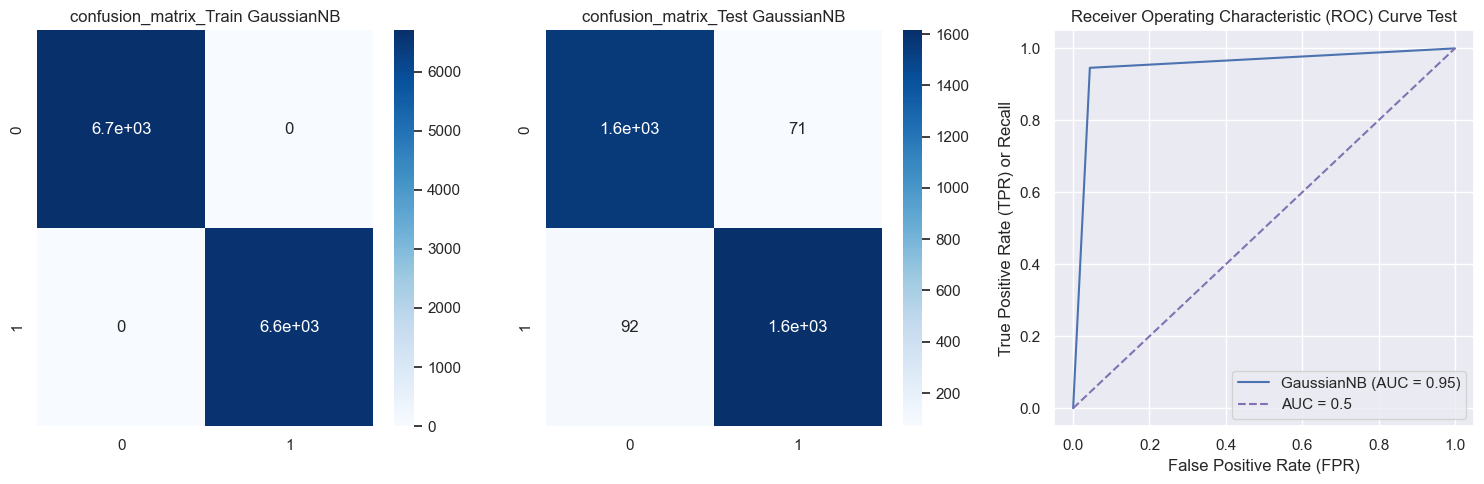

,Model,Train_auc_score,Train_accuracy,CV_Mean_Train_Accuracy,Train_f1,Test_auc_score,Test_accuracy,CV_Mean_Test_Accuracy,Test_f1
0,RandomForestClassifier,1.0,1.0,0.946,1.0,0.991,0.951,0.946,0.952


In [57]:
clf_rf = RandomForestClassifier(random_state=42, n_estimators=100)
clf_rf.fit(x_train, y_train)
y_pred_train_rf= clf_rf.predict(x_train)
y_pred_test_rf= clf_rf.predict(x_test)

Train_AUC_rf = roc_auc_score(y_train,clf_rf.predict_proba(x_train)[:,1])
Train_accuracy_rf = accuracy_score(y_train,y_pred_train_rf)
Train_f1_rf = f1_score(y_train,y_pred_train_rf)

Test_AUC_rf = roc_auc_score(y_test,clf_rf.predict_proba(x_test)[:,1])
Test_accuracy_rf = accuracy_score(y_test,y_pred_test_rf)
Test_f1_rf = f1_score(y_test,y_pred_test_rf)

# Cross Validation 
rf_train_accuracy = cross_val_score(clf_rf, x_train, y_train, cv=10).mean()
rf_test_accuracy = cross_val_score(clf_rf, x_test, y_test, cv=10).mean()


####visualizations

cm_test = confusion_matrix(y_test, y_pred_test_rf)
cm_train = confusion_matrix(y_train, y_pred_train_rf)   

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(cm_train, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Train GaussianNB')

plt.subplot(1,3,2)
sns.heatmap(cm_test, annot = True, cmap= 'Blues')
plt.title(f'confusion_matrix_Test GaussianNB')


plt.subplot(1,3,3)
fpr, tpr, _ = roc_curve(y_test, y_pred_test_rf, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'GaussianNB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'm--', label='AUC = 0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#Summary table

summary_table = PrettyTable(["Model", "Train_auc_score", "Train_accuracy",'CV_Mean_Train_Accuracy',"Train_f1" ,"Test_auc_score",'Test_accuracy','CV_Mean_Test_Accuracy' ,'Test_f1']) #heading
summary_table.add_row(["RandomForestClassifier",round(Train_AUC_rf,3),round(Train_accuracy_rf, 3),round(rf_train_accuracy ,3), round(Train_f1_rf,3),round(Test_AUC_rf,3),round(Test_accuracy_rf,3),round(rf_train_accuracy ,3), round(Test_f1_rf,3) ])

table = pd.read_html(summary_table.get_html_string())
RandomForest_Classifier_Result = table[0]
RandomForest_Classifier_Result

# Model Comparison

In [65]:
Model_Result = [Gaussian_NB_Classifier_Result,Bernoulli_NB_Classifier_Result,Multinomial_NB_Classifier_Result,RandomForest_Classifier_Result] 
result = pd.concat(Model_Result,ignore_index=True)
(result).sort_values(by=['CV_Mean_Test_Accuracy'],ascending=False)

,Model,Train_auc_score,Train_accuracy,CV_Mean_Train_Accuracy,Train_f1,Test_auc_score,Test_accuracy,CV_Mean_Test_Accuracy,Test_f1
3,RandomForestClassifier,1.000,1.000,0.946,1.000,0.991,0.951,0.946,0.952
2,MultinomialNB,0.993,0.956,0.929,0.954,0.990,0.940,0.909,0.938
1,BernoulliNB,0.952,0.857,0.841,0.866,0.941,0.853,0.814,0.864
0,GaussianNB,0.880,0.881,0.795,0.864,0.806,0.801,0.742,0.760


<Figure size 1000x1000 with 0 Axes>

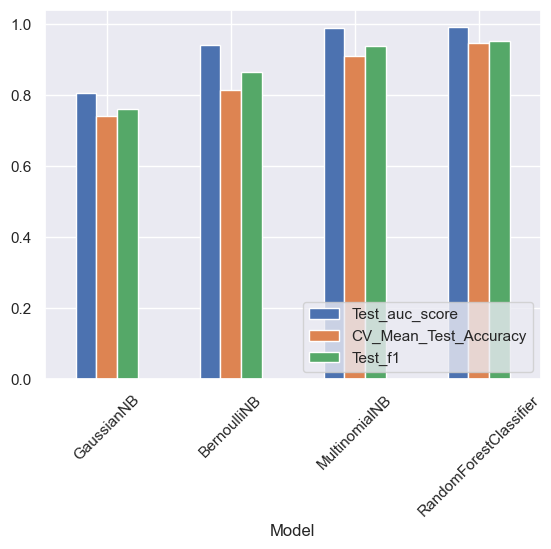

In [66]:
plt.figure(figsize=(10,10))
result[['Test_auc_score','CV_Mean_Test_Accuracy','Test_f1']].set_index(result.Model).plot( kind='bar', rot=45)
plt.legend(loc= 'lower right')
plt.show()

# ROC AUC Characteristics

In [67]:
models_preds = {'GaussianNB':y_pred_test_gnb, 
           'BernoulliNB': y_pred_test_bnb, 
            'MultinomialNB': y_pred_test_mnb, 
          'RandomForestClassifier':y_pred_test_rf}
models_preds=pd.DataFrame(models_preds)
models_preds

,GaussianNB,BernoulliNB,MultinomialNB,RandomForestClassifier
0,0,1,1,1
1,1,1,0,1
2,0,0,0,0
3,1,0,1,1
4,1,1,1,1
...,...,...,...,...
3323,1,1,1,1
3324,0,1,0,0
3325,0,1,1,1
3326,1,0,1,1


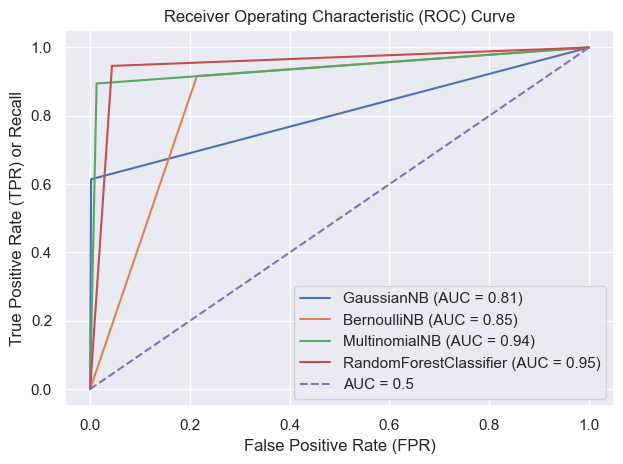

In [68]:
for i in range(4):
    fpr, tpr, thresholds = roc_curve(y_test, models_preds.iloc[:,i])# The confidence score for a sample is proportional to the signeddistance of that sample to the hyperplane.
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{models_preds.columns[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'm--', label='AUC = 0.5')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [69]:
import joblib
joblib.dump(clf_rf, 'Random_forest.pkl')

['Random_forest.pkl']

# Conclusion

we have applied GaussianNB , BernoulliNB, MultinomialNB and RandomForest classifier. 
Random forest classifier gives amazing result in both accuracy and AUC. It is classifieng test data with AUC is .95 with 94.6% 
mean accuracy.Similar metrics are for train data.its not overfitting.

MultinomialNB is also giving better Accuracy of 90% with AUC score of 0.94

The model can be further improved if we use Word2Vec verctorizer as well wil DL model as LSTM/GRU